<a id='8'></a> 
# Описание проекта "Авиарейсы без потерь".

## Цель проекта.

Определение убыточных авиарейсов из города Анапы на основе датасета полетов за 2017 год.

## Задачи проекта.

Для достижения поставленной цели необходимым видится решение следующих задач:

<a href='#1'>Введение.

<a href='#2'>2. Первичный осмотр данных.

<a href='#3'>3. Анализ рисков дополнительных расходов.
    
<a href='#4'>4. Определение расходов.
    
<a href='#5'>5. Определение малоприбыльных рейсов.

<a href='#6'>Вывод.


<a id='1'></a> 
### Введение

В качестве метрики, по которой будем судить о малоприбыльности будем считать рентабельность продаж - отношение чистой прибыли к выручке.

Установим порог рентабельности довольно высоким - 40%, ввиду того, что у нас отсутствуют данные о себестоимости лизинга, расходов на аэронавигацию и административный персонал. Все вышеперечисленные данные являются коммерческой тайной и не попадают в открытый доступ.

Чистая прибыль представляет собой выручку - расходы.

#### Загрузка билиотек и установка форматов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format ='{:,.2f}'.format
import warnings
warnings.simplefilter('ignore')

# Добавим метод чтобы красиво отобржать текст
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

#### Загрузка датасета.

In [2]:
#Загружаем датасет
#data = pd.read_csv(r'C:\Users\lsdes\YandexDisk\SkillFactory\module_4\final_proj\result.csv')
data = pd.read_csv(r'C:\Users\Alex\YandexDisk\SkillFactory\module_4\final_proj\result.csv')

#### Преобразование столбцов с датой.

In [3]:
#Преобразование столбцов с датой из str в datetime
datetime_col = ['scheduled_departure','actual_departure']
for col in datetime_col:
    data[col] = pd.to_datetime(data[col])

#### Преобразование времени полета в количество часов.

In [4]:
#Преобразуем значение параметра flight_time - 
#в челочисленный, содержащий количество часов, округленное в бОльшую сторону
def flight_time_conv(flight_time):
    #разделим строку по пробелам. 6 - элемент часы, 8 - элемент минуты.
    time = flight_time.split(' ')
    
    #Если есть хотя бы 1 минута, округляем в большую сторону
    if int(time[8])>0: return int(time[6]) + 1
    else: return int(time[6])

#Время полета в часах сохраним в столбце flight_time_hours
data['flight_time_hours'] = data['flight_time'].apply(flight_time_conv)

<a id='2'></a> 
### 2. Первичный осмотр данных.

In [5]:
data.head()

,flight_id,flight_no,scheduled_departure,actual_departure,flight_time,departure_city,arrival_city,distance,model,sold_seat_eco,sold_seat_bus,total_amount,flight_time_hours
0,41246,PG0251,2017-01-31 15:05:00+00:00,2017-01-31 15:08:00+00:00,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,Moscow,Anapa,"1,219.06",Boeing 737-300,102,11,"1,654,200.00",2
1,41250,PG0251,2017-02-05 15:05:00+00:00,2017-02-05 15:13:00+00:00,0 years 0 mons 0 days 1 hours 43 mins 0.00 secs,Moscow,Anapa,"1,219.06",Boeing 737-300,105,10,"1,654,200.00",2
2,41253,PG0251,2017-02-01 15:05:00+00:00,2017-02-01 15:09:00+00:00,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,Moscow,Anapa,"1,219.06",Boeing 737-300,103,12,"1,703,000.00",2
3,41258,PG0251,2017-02-04 15:05:00+00:00,2017-02-04 15:12:00+00:00,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,Moscow,Anapa,"1,219.06",Boeing 737-300,97,10,"1,555,400.00",2
4,41259,PG0251,2017-02-03 15:05:00+00:00,2017-02-03 15:09:00+00:00,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,Moscow,Anapa,"1,219.06",Boeing 737-300,102,10,"1,617,600.00",2


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   flight_id            236 non-null    int64              
 1   flight_no            236 non-null    object             
 2   scheduled_departure  236 non-null    datetime64[ns, UTC]
 3   actual_departure     236 non-null    datetime64[ns, UTC]
 4   flight_time          236 non-null    object             
 5   departure_city       236 non-null    object             
 6   arrival_city         236 non-null    object             
 7   distance             236 non-null    float64            
 8   model                236 non-null    object             
 9   sold_seat_eco        236 non-null    int64              
 10  sold_seat_bus        236 non-null    int64              
 11  total_amount         236 non-null    float64            
 12  flight_time_hours    2

В датасете содержится 236 записей об авиарейсах из/в Анапу. Пропусков нет.
6 столбцов содержат числовые данные, 5 - строковые или иные, 2 - дата_время.

<a id='3'></a> 
### 3. Анализ рисков дополнительных расходов.

К рискам дополнительных расходов можно отнести задержку вылета и риск недостаточного спроса. 

#### 3.1. Задержки вылета.

При задержке вылета более 4 часа (240 минут) перевозчик обязан предоставить пассажирам горячее питание, кроме того, дополнительное время нахождения борта повлечет расходы на обслуживание аэропорта.

In [7]:
data['delay_preiod'] = round((data.actual_departure - data.scheduled_departure).dt.total_seconds()/60,0)

Определим, какое количество рейсов задержалось на срок более 4 часов (240 минут). Данные рейсы могли стать источником дополнительных расходов.

In [8]:
data[data['delay_preiod'] > 240]['flight_id'].count()

0

Рейсов с задержкой более 4 часов в датасете нет. Рисков, связанных с дополнительными расходами из-за задержки рейсов нет. 

<a id='4'></a> 
### 4. Определение расходов.

Общая сумма расходов будет складываться из:
- Стоимость топлива
- Расходы на обслуживание аэропорта
- Заработная плата экипажа

#### Стоимость топлива.
Расход топлива зависит от модели воздушного судна. Определим, какие модели летали из/в Анапу.

In [9]:
data['model'].unique()

array(['Boeing 737-300', 'Sukhoi Superjet-100'], dtype=object)

В датасете представлено две модели.
По данным Wiki (https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft) расход топлива для Boeing 737-300 составляет 3.49 кг/км, а для Sukhoi Superjet-100 - 2.81 кг/км.
Внесем эти значения в параметр fuel_consumption.

In [10]:
data['fuel_consumption'] = data['model'].apply(lambda x: 3.49 if x == 'Boeing 737-300' else 2.81)


Поскольку направление рейсов разное, будем использовать цену аваиционного керосина при заправке в городе Анапа. Стоимость возьмем из данных Ростата за август 2017 года (https://favt.gov.ru/public/materials/a/1/f/1/6/a1f1621a3625b71cc32d275d5b7f8b0b.pdf) ~ 42 т.р. за тонну.

Итоговые расходы на топливо получим по формуле: (дистанция / расход) * стоиомость.

In [11]:
data['fuel_cost'] = (data['distance'] / data['fuel_consumption']/1000) * 42000

#### Обслуживание аэропорта.

По данным из нескольких источников, стоимость обслуживания борта в аэропорту зависит от города. Итоговая сумма варьируется от 40 до 100 т.р. Возьмем среднее значение 70 т.р. + противооблединительная обработка 1300$ или 90 т.р.
Отдельно считаем обслуживание пассажиров в аэропорту. Расходы на пассажира эконом класса в среднем составляют 1000 р. на человека (прохождение регистрации, досмотра, подача трапа и т.д.), бизнес - 12000 р. на человека (VIP-зал, приоритетное обслуживание и т.п.).
Итоговую сумму сбора аэропорта внесем в столбец 'airport_service_cost'

In [12]:
data['airport_service_cost'] = data['sold_seat_eco']*1000 + data['sold_seat_bus']*12000 + 70000 + 90000

#### Оплата услуг экипажа

В экипаж входят пилоты и борт-проводники. На всех современных авиалайнерах присутствуют по 2 пилота. Количество борт-проводников зависит от типа самолета. Для присутсвующих в датасете Boeing 737-300 - это 5 человек, для Sukhoi Superjet-100 - 4.
Средняя заработная плата пилота 250 т.р. на руки при 160 часах в месяц.
Средняя заработная плата борт-проводника 140 т.р. на руки при 160 часах в месяц.

Напишем функцию для подсчета стоимости расходов на экипаж в зависимости от модели самолета и времени полета.

In [13]:
def crew_cost(airplane_model, flight_time):
    """Подсчет расходов на оплату экипажа. Вход: airplane_model - модель самолета, flight_time - время полета. 
       Выход - стоимость в рублях"""
    
    #steward_num - количество борт-проводников
    steward_num = 0
    if airplane_model == 'Boeing 737-300': steward_num = 5
    elif airplane_model == 'Sukhoi Superjet-100': steward_num = 4
            
    pilot_num = 2
    
    #pilot_salary - зарплата пилота на руки
    #steward_salary - зарплата борт-проводника на руки
    pilot_salary = 250000
    steward_salary = 140000
    
    #work_hours_month - количество рабочих часов в месяц
    work_hours_month = 160
    
    #общая стоимость всех рахсодов на содержание экипажа. 
    #(Месячные расходы на экипаж с учетом налогов / количество рабочих часов ) * время полета+2часа 
                                                                        #на подгтовку рейса и постпосадочные процедуры.
    month_crew_cost = ((pilot_salary*pilot_num + steward_salary*steward_num)/(0.87*0.74))/work_hours_month*(flight_time+2)
    
    return(month_crew_cost)
    


Вычислим затраты на экипаж и поместим значение в столбец crew_cost.

In [14]:
data['crew_cost'] = data.apply(lambda x: crew_cost(x.model,x.flight_time_hours), axis=1)

<a id='5'></a> 
### 5. Определение малоприбыльных рейсов.

Вычислим рентабельность продаж. Полученные значения запишем в столбец profit_margin.

In [15]:
data['profit_margin'] = (data['total_amount'] - data['fuel_cost'] - data['airport_service_cost'] - data['crew_cost'])\
    / data['total_amount']

Изначально было решено использовать значение 40%, как порог убыточности. Определим ID рейсов, рентабельность продаж которых менее 40%.

In [16]:
display(data[data.profit_margin < 0.4][['flight_id','departure_city','arrival_city','scheduled_departure']])
print("Итого убыточных рейсов:", data[data.profit_margin < 0.4]['flight_id'].count())

,flight_id,departure_city,arrival_city,scheduled_departure
122,136609,Anapa,Belgorod,2017-01-08 09:25:00+00:00
124,136620,Anapa,Belgorod,2017-02-17 09:25:00+00:00
127,136642,Anapa,Belgorod,2017-01-30 09:25:00+00:00
128,136645,Anapa,Belgorod,2017-01-05 09:25:00+00:00
136,136678,Anapa,Belgorod,2017-01-28 09:25:00+00:00
146,136767,Anapa,Belgorod,2017-01-23 09:25:00+00:00
152,136807,Anapa,Belgorod,2017-02-23 09:25:00+00:00
155,136823,Anapa,Belgorod,2017-02-05 09:25:00+00:00
159,136844,Anapa,Belgorod,2017-02-28 09:25:00+00:00
166,136887,Anapa,Belgorod,2017-01-20 09:25:00+00:00


Итого убыточных рейсов: 16


Убыточные рейсы были только из/в город Белгород.
Определим количество убыточных рейсов относительного общего числа рейсов и отдельно по белогородскому направлению.

In [17]:
data['profit'] = data.profit_margin.apply(lambda x: 0 if x < 0.4 else 1)

### Общее распределение убыточных и прибыльных рейсов.

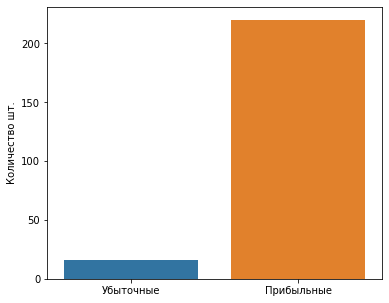

Процент убыточных рейсов относительно общего числа: 7 %


In [18]:
printmd('### ' + str('Общее распределение убыточных и прибыльных рейсов.'))
fig, ax = plt.subplots(figsize=(6, 5))
pp = sns.countplot(data.loc[:, 'profit'], ax=ax)
pp.axes.set_xticks([0,1])
pp.axes.set_xticklabels(['Убыточные','Прибыльные'])
plt.xlabel('')
plt.ylabel('Количество шт.')
plt.show()
print('Процент убыточных рейсов относительно общего числа:',\
      round(data.groupby(['profit'])['flight_id'].count()[0]/data.groupby(['profit'])['flight_id'].count()[1]*100),"%")

In [19]:
data_belgorod = data[(data.departure_city == 'Belgorod') | (data.arrival_city == 'Belgorod')].copy()

### Распределение убыточных и прибыльных рейсов по направлению в Белгород.

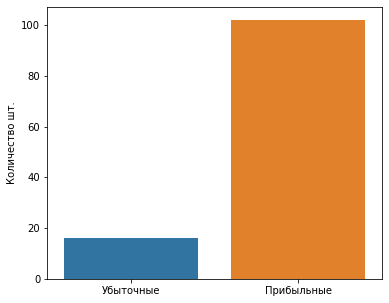

Процент убыточных рейсов по белогородскому направлению: 16 %


In [20]:
printmd('### ' + str('Распределение убыточных и прибыльных рейсов по направлению в Белгород.'))
fig, ax = plt.subplots(figsize=(6, 5))
pp = sns.countplot(data_belgorod.loc[:, 'profit'], ax=ax)
pp.axes.set_xticks([0,1])
pp.axes.set_xticklabels(['Убыточные','Прибыльные'])
plt.xlabel('')
plt.ylabel('Количество шт.')
plt.show()
print('Процент убыточных рейсов по белогородскому направлению:',\
      round(data_belgorod.groupby(['profit'])['flight_id'].count()[0]/\
            data_belgorod.groupby(['profit'])['flight_id'].count()[1]*100),"%")

<a id='6'></a> 
### Вывод.

Вычислив сумму доходов и расходов, связанных с авиарейсами, удалось определить, какие рейсы в 2017 году были малоприбыльными. Убыточным оказалось направление в город Белгород. 16 процентов рейсов по данному направлению не принесли должного уровня прибыли.
Список убыточных рейсов еще раз продублирован ниже.

In [21]:
data[data.profit_margin < 0.4][['flight_id','flight_no','departure_city','arrival_city','scheduled_departure']]

,flight_id,flight_no,departure_city,arrival_city,scheduled_departure
122,136609,PG0480,Anapa,Belgorod,2017-01-08 09:25:00+00:00
124,136620,PG0480,Anapa,Belgorod,2017-02-17 09:25:00+00:00
127,136642,PG0480,Anapa,Belgorod,2017-01-30 09:25:00+00:00
128,136645,PG0480,Anapa,Belgorod,2017-01-05 09:25:00+00:00
136,136678,PG0480,Anapa,Belgorod,2017-01-28 09:25:00+00:00
146,136767,PG0480,Anapa,Belgorod,2017-01-23 09:25:00+00:00
152,136807,PG0480,Anapa,Belgorod,2017-02-23 09:25:00+00:00
155,136823,PG0480,Anapa,Belgorod,2017-02-05 09:25:00+00:00
159,136844,PG0480,Anapa,Belgorod,2017-02-28 09:25:00+00:00
166,136887,PG0480,Anapa,Belgorod,2017-01-20 09:25:00+00:00
